<a href="https://colab.research.google.com/github/rachelszeto/Projects/blob/main/DataBlog_SpendingHabits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.interpolate import make_interp_spline
import statsmodels.api as sm
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

In [2]:
# Load the Dataset

dataset_link = '/content/drive/MyDrive/DataBlog - Spending Habits/spending_patterns_detailed.csv'
dataset = pd.read_csv(dataset_link)

# Check load correctly
dataset.head()

,Customer ID,Category,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,CUST_0159,Groceries,Milk,1,1.28,1.28,Debit Card,Mobile App,2024-11-13
1,CUST_0017,Friend Activities,Dinner with Friends,2,74.69,149.39,Debit Card,In-store,2023-05-04
2,CUST_0094,Housing and Utilities,Water Bill,1,76.06,76.06,Digital Wallet,Mobile App,2023-12-16
3,CUST_0162,Fitness,Yoga Class,5,11.24,56.18,Cash,In-store,2024-01-28
4,CUST_0129,Gifts,Flowers,3,43.71,131.12,Debit Card,In-store,2023-07-28


In [ ]:
dataset.isnull().sum()

,0
Customer ID,0
Category,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0


In [ ]:
dataset.describe()

,Quantity,Price Per Unit,Total Spent
count,10000.000000,10000.000000,10000.000000
mean,2.237200,969.957948,2534.750890
std,1.481133,6104.403843,19676.741772
min,1.000000,1.000000,1.110000
25%,1.000000,12.960000,25.957500
50%,1.000000,51.860000,88.115000
75%,3.000000,177.587500,336.375000
max,5.000000,74246.460000,352230.760000


# EXPLORATORY DATA ANALYSIS

### How does spending fluctuate over time (e.g., seasonal trends, month-to-month changes)?

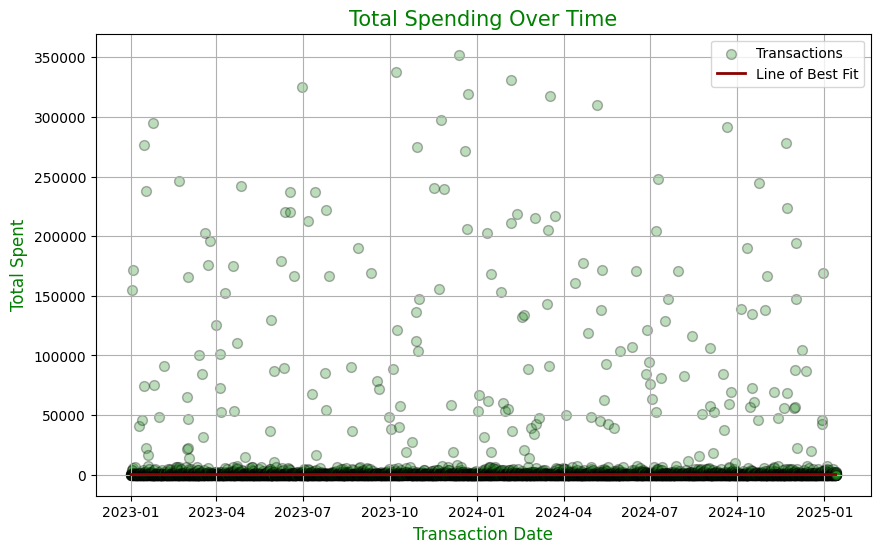

In [ ]:
# How does spending fluctuate over time (e.g., seasonal trends, month-to-month changes)?
dataset["Transaction Date"] = pd.to_datetime(dataset["Transaction Date"], errors="coerce")
dataset = dataset.sort_values("Transaction Date")

plt.figure(figsize=(10, 6))
plt.scatter(dataset["Transaction Date"], dataset["Total Spent"], alpha=0.3, color="forestgreen", edgecolors="black", s=50, marker="o", label="Transactions")

lowess = sm.nonparametric.lowess(dataset["Total Spent"], dataset["Transaction Date"].astype(int), frac=0.2)
plt.plot(pd.to_datetime(lowess[:, 0]), lowess[:, 1], color="darkred", linewidth=2, label="Line of Best Fit")

plt.title("Total Spending Over Time", fontsize=15, color="green")
plt.xlabel("Transaction Date", fontsize=12, color="green")
plt.ylabel("Total Spent", fontsize=12, color="green")
plt.grid(True)
plt.legend()
plt.show()

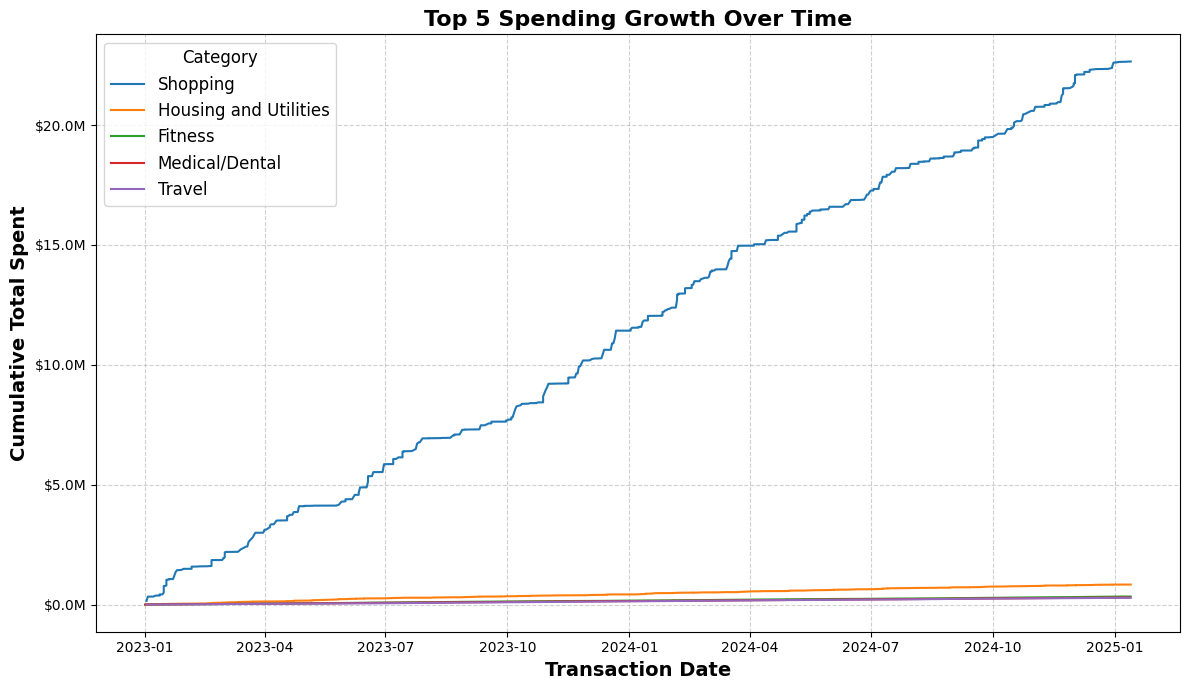

In [13]:
# Convert 'Transaction Date' to datetime and sort the dataset
dataset["Transaction Date"] = pd.to_datetime(dataset["Transaction Date"], errors="coerce")
dataset = dataset.sort_values("Transaction Date")

# Calculate cumulative totals by category
dataset["Cumulative Total"] = dataset.groupby("Category")["Total Spent"].cumsum()

# Identify the top 5 most notable categories based on total spending
top_categories = dataset.groupby("Category")["Total Spent"].sum().nlargest(5).index

# Create the plot
plt.figure(figsize=(12, 7))

for category in top_categories:
    subset = dataset[dataset["Category"] == category]
    plt.plot(subset["Transaction Date"], subset["Cumulative Total"], label=category, linestyle="solid")

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e6:.1f}M"))

# Improve readability with larger labels and title
plt.title("Top 5 Spending Growth Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Transaction Date", fontsize=14, fontweight="bold")
plt.ylabel("Cumulative Total Spent", fontsize=14, fontweight="bold")

# Improve legend readability
plt.legend(title="Category", loc="upper left", fontsize=12, title_fontsize=12)

# Add grid for better visual clarity
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

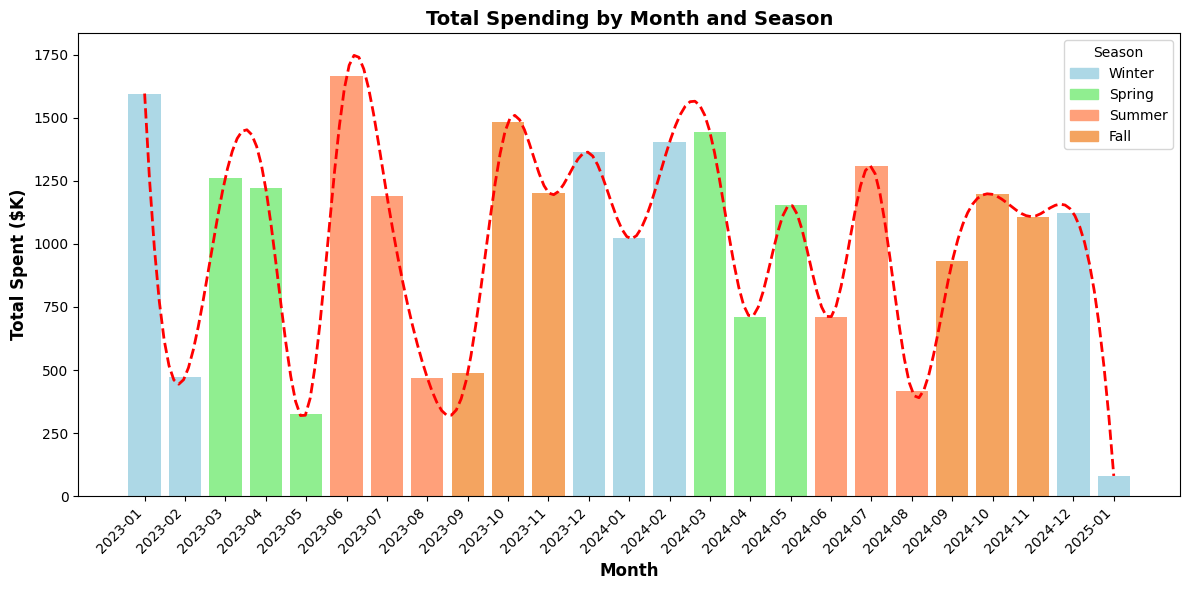

In [ ]:
# Convert 'Transaction Date' to datetime format and to thousands
dataset['Transaction Date'] = pd.to_datetime(dataset['Transaction Date'], errors='coerce')
dataset["Total Spent ($K)"] = dataset["Total Spent"] / 1000

# Extract Year-month for aggregation
dataset["Year-Month"] = dataset["Transaction Date"].dt.to_period("M")

# Group by month and sum the total spending
monthly_spending = dataset.groupby("Year-Month")["Total Spent ($K)"].sum().reset_index()

# Convert period to string for plotting
monthly_spending["Year-Month"] = monthly_spending["Year-Month"].astype(str)

# Define seasonal colors
season_colors = {
    "Winter": "lightblue",
    "Spring": "lightgreen",
    "Summer": "lightsalmon",
    "Fall": "sandybrown",
}

# Assign colors based on seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

monthly_spending["Season"] = monthly_spending["Year-Month"].apply(lambda x: get_season(int(x.split("-")[1])))
monthly_spending["Color"] = monthly_spending["Season"].map(season_colors)

# Plot the data
plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_spending["Year-Month"], monthly_spending["Total Spent ($K)"],
               color=monthly_spending["Color"])

# Add smoother trendline
x = np.arange(len(monthly_spending))
y = monthly_spending["Total Spent ($K)"]

spline = make_interp_spline(x, y, k=3)
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth = spline(x_smooth)

plt.plot(x_smooth, y_smooth, color="red", linestyle="--", linewidth=2, label="Trendline")

# Labels and title
plt.xlabel("Month", fontsize=12, fontweight="bold")
plt.ylabel("Total Spent ($K)", fontsize=12, fontweight="bold")
plt.title("Total Spending by Month and Season", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right")

# Legend for seasons
legend_patches = [mpatches.Patch(color=color, label=season) for season, color in season_colors.items()]
plt.legend(handles=legend_patches, title="Season", loc="upper right")

# Display the plot
plt.tight_layout()
plt.show()

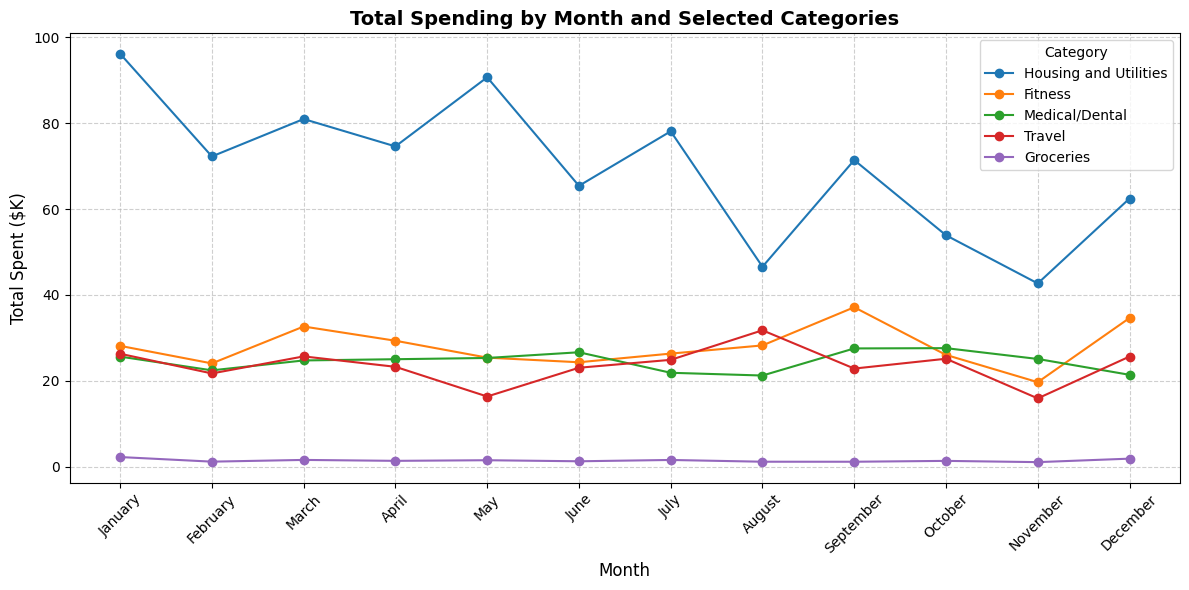

In [11]:
# Convert 'Transaction Date' to datetime and sort the dataset
dataset['Transaction Date'] = pd.to_datetime(dataset['Transaction Date'], errors='coerce')
dataset = dataset.sort_values("Transaction Date")

# Convert Total Spent to thousands for easier interpretation
dataset["Total Spent ($K)"] = dataset["Total Spent"] / 1000

# Extract month names from Transaction Date
dataset["Month"] = dataset["Transaction Date"].dt.strftime('%B')

# Define the selected categories (excluding Shopping)
selected_categories = ["Housing and Utilities", "Fitness", "Medical/Dental", "Travel", "Groceries"]

# Filter dataset for the selected categories
filtered_dataset = dataset[dataset["Category"].isin(selected_categories)]

# Aggregate spending by month and category for the selected categories
monthly_spending = filtered_dataset.groupby(["Month", "Category"])["Total Spent ($K)"].sum().unstack()

# Ensure months are ordered chronologically
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
monthly_spending = monthly_spending.reindex(month_order)

# Plot multiline graph
plt.figure(figsize=(12, 6))
for category in selected_categories:
    plt.plot(month_order, monthly_spending[category], marker='o', linestyle='-', label=category)

plt.title('Total Spending by Month and Selected Categories', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Spent ($K)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

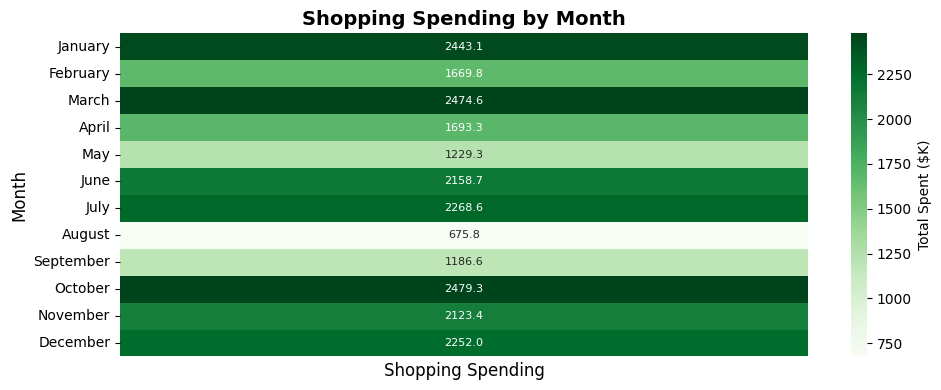

In [10]:
# Now create a separate heatmap for Shopping spending with a green variation
shopping_data = dataset[dataset["Category"] == "Shopping"]
shopping_monthly = shopping_data.groupby("Month")["Total Spent ($K)"].sum().reindex(month_order)

plt.figure(figsize=(10, 4))
sns.heatmap(shopping_monthly.to_frame(), cmap='Greens', annot=True, fmt='.1f',
            cbar_kws={"label": "Total Spent ($K)"}, annot_kws={'size': 8})
plt.title('Shopping Spending by Month', fontsize=14, fontweight='bold')
plt.xlabel('Shopping Spending', fontsize=12)
plt.ylabel("Month", fontsize=12)
plt.xticks([])
plt.tight_layout()
plt.show()

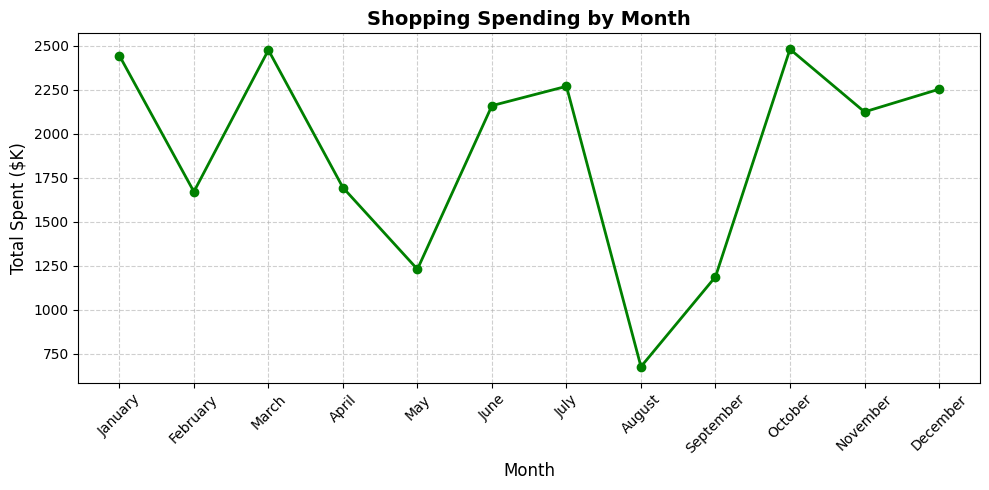

In [12]:
# Convert 'Transaction Date' to datetime and sort the dataset
dataset['Transaction Date'] = pd.to_datetime(dataset['Transaction Date'], errors='coerce')
dataset = dataset.sort_values("Transaction Date")

# Convert Total Spent to thousands for easier interpretation
dataset["Total Spent ($K)"] = dataset["Total Spent"] / 1000

# Extract month names from Transaction Date
dataset["Month"] = dataset["Transaction Date"].dt.strftime('%B')

# Ensure months are ordered chronologically
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

# Filter dataset for Shopping category
shopping_data = dataset[dataset["Category"] == "Shopping"]

# Aggregate spending by month for Shopping
shopping_monthly = shopping_data.groupby("Month")["Total Spent ($K)"].sum().reindex(month_order)

# Plot the line graph
plt.figure(figsize=(10, 5))
plt.plot(shopping_monthly.index, shopping_monthly.values, marker='o', linestyle='-', color='green', linewidth=2, markersize=6)
plt.title('Shopping Spending by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel("Total Spent ($K)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

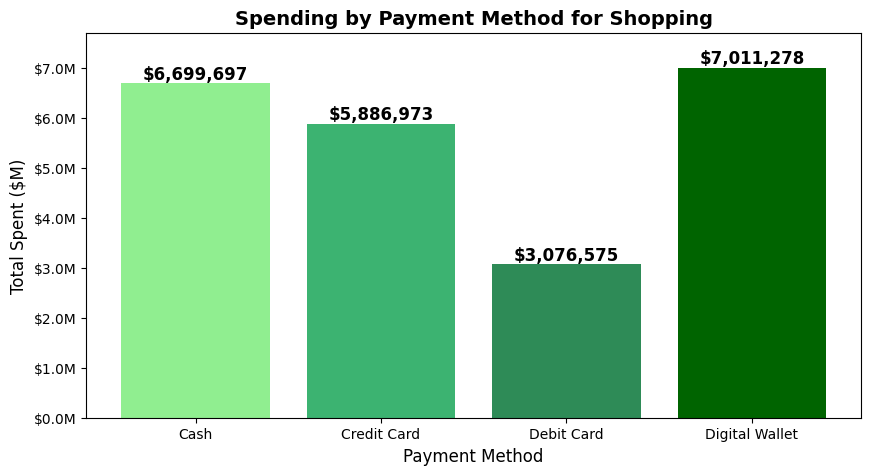

In [7]:
# Convert 'Transaction Date' to datetime format
dataset['Transaction Date'] = pd.to_datetime(dataset['Transaction Date'], errors='coerce')

# Identify the top category with the highest total spending
top_category = dataset.groupby("Category")["Total Spent"].sum().nlargest(1).index[0]

# Filter dataset to include only the top category
filtered_dataset = dataset[dataset["Category"] == top_category]

# Aggregate data by payment method for the top category
payment_summary = filtered_dataset.groupby("Payment Method")["Total Spent"].sum().reset_index()

# Sample data for Spending by Payment Method for Shopping
payment_methods = ["Cash", "Credit Card", "Debit Card", "Digital Wallet"]
total_spent = [6699697, 5886973, 3076575, 7011278]  # Example amounts

# Create bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(payment_methods, total_spent, color=['lightgreen', 'mediumseagreen', 'seagreen', 'darkgreen'])

# Format y-axis for better readability
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Add labels on top of bars
for bar, amount in zip(bars, total_spent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'${amount:,.0f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize chart appearance
plt.title("Spending by Payment Method for Shopping", fontsize=14, fontweight="bold")
plt.xlabel("Payment Method", fontsize=12)
plt.ylabel("Total Spent ($M)", fontsize=12)
plt.ylim(0, max(total_spent) * 1.1)

# Show the updated bar chart
plt.show()